# Imports

In [1]:
# Imports

import os
import pandas as pd
import numpy as np
import umap
from sklearn.model_selection import train_test_split
#import umap.plot
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import calibration_curve

from ignite_lume.lume import Lume, LumeElement, LumeDataset
from ignite_lume.lume_types import LumeFile, LumeText

from pathlib import Path
import re
from tqdm import tqdm

/Users/dscripka/anaconda3/envs/ignite@v1.3.0/lib/python3.6/site-packages/ignite_lume/logging/config.py:143: UserWarning: no logging configuration found at: 'logging_config.yml'
  warnings.warn(f"no logging configuration found at: '{_cfg_path}'")


In [2]:
# Load CUAD dataset

lumes = [Lume.load(i) for i in Path("/Users/dscripka/Documents/datasets/CUAD_v1/lumes").glob("**/*.json")]
len(lumes)

510

In [56]:
# Get texts for anti-assignment and all other fields

excluded = ["__elem__token", "__elem__sentence", "__elem__entity"]

anti_assign_text = [LumeText(lm).get_text_from_element(el) for lm in lumes for el in lm.elements if el.element_type == '__elem__Anti-Assignment']
other_text = [LumeText(lm).get_text_from_element(el) for lm in lumes for el in lm.elements if el.element_type != '__elem__Anti-Assignment' and el.element_type not in excluded]


all_text = anti_assign_text + other_text
labels = [1]*len(anti_assign_text) + [0]*len(other_text)
len(labels)

13823

In [57]:
# View some example texts

anti_assign_text[1:3]

['Operator shall not make any assignment of all or any part of this Agreement or any of the rights or obligations hereunder unless there first shall  have been obtained the written consent thereto of Owner, which consent shall not be unreasonably withheld, conditioned, or delayed.',
 'Any attempted assignment of this Agreement in violation of this Section 9.13 shall be null and void.']

# Probabilities and Calibration

## Logistic Regression

In [58]:
# Get dataset splits randomly
X_train, X_test, y_train, y_test = train_test_split(all_text, labels, test_size=0.2, random_state=1, stratify=labels)

# Define TF-IDF features
feats = TfidfVectorizer(stop_words='english', ngram_range=(1,1), lowercase=True, max_features=1000)
feats.fit(X_train)

# Get TF-IDF features
X_train_tfidf = feats.transform(X_train)
X_test_tfidf = feats.transform(X_test)

# Define and train model
clf = LogisticRegression()
clf.fit(X_train_tfidf, y_train)

# Get predictions and view performance
y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2634
           1       0.88      0.69      0.77       131

    accuracy                           0.98      2765
   macro avg       0.93      0.84      0.88      2765
weighted avg       0.98      0.98      0.98      2765



In [59]:
# Create calibrated model using platt scaling

from sklearn.calibration import CalibratedClassifierCV

calibrated_clf = CalibratedClassifierCV(base_estimator=clf, cv=5, method="isotonic")
calibrated_clf.fit(X_train_tfidf, y_train)

# Get predictions and view performance
y_pred = calibrated_clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2634
           1       0.85      0.76      0.80       131

    accuracy                           0.98      2765
   macro avg       0.92      0.87      0.90      2765
weighted avg       0.98      0.98      0.98      2765



Text(0, 0.5, 'Actual Probability')

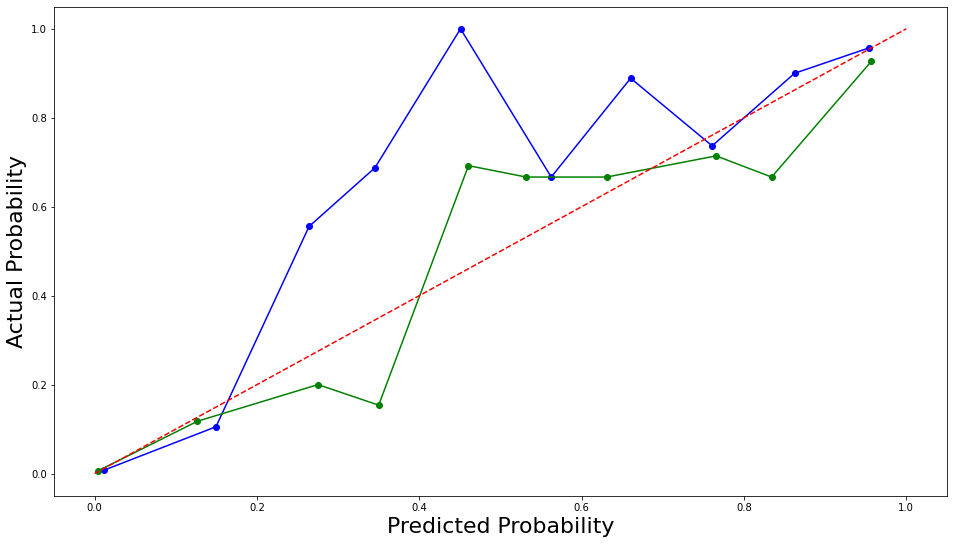

In [60]:
# Plot model calibration curve

prob_true, prob_pred = calibration_curve(y_test,  clf.predict_proba(X_test_tfidf)[:,1], n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, calibrated_clf.predict_proba(X_test_tfidf)[:,1], n_bins=10)

plt.figure(figsize=(16,9))
_ = plt.plot(prob_pred, prob_true, 'bo-')
_ = plt.plot(prob_pred_cal, prob_true_cal, 'go-')
_ = plt.plot([0,1], [0,1], 'r--')
plt.xlabel("Predicted Probability", fontsize=22)
plt.ylabel("Actual Probability", fontsize=22)

## Simple Neural Network

In [66]:
from sklearn.neural_network import MLPClassifier

clf_nn = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(128,128,2),
                       batch_size=64, max_iter=30, learning_rate_init=0.01)
clf_nn.fit(X_train_tfidf, y_train)

y_pred = clf_nn.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2634
           1       0.77      0.84      0.81       131

    accuracy                           0.98      2765
   macro avg       0.88      0.91      0.90      2765
weighted avg       0.98      0.98      0.98      2765



/Users/dscripka/anaconda3/envs/ignite@v1.3.0/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [67]:
# Create calibrated model using platt scaling

from sklearn.calibration import CalibratedClassifierCV

calibrated_clf = CalibratedClassifierCV(base_estimator=clf_nn, cv=5, method="isotonic")
calibrated_clf.fit(X_train_tfidf, y_train)

# Get predictions and view performance
y_pred = calibrated_clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

/Users/dscripka/anaconda3/envs/ignite@v1.3.0/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/dscripka/anaconda3/envs/ignite@v1.3.0/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/dscripka/anaconda3/envs/ignite@v1.3.0/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/dscripka/anaconda3/envs/ignite@v1.3.0/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stoc

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2634
           1       0.81      0.77      0.79       131

    accuracy                           0.98      2765
   macro avg       0.90      0.88      0.89      2765
weighted avg       0.98      0.98      0.98      2765



/Users/dscripka/anaconda3/envs/ignite@v1.3.0/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Text(0, 0.5, 'Actual Probability')

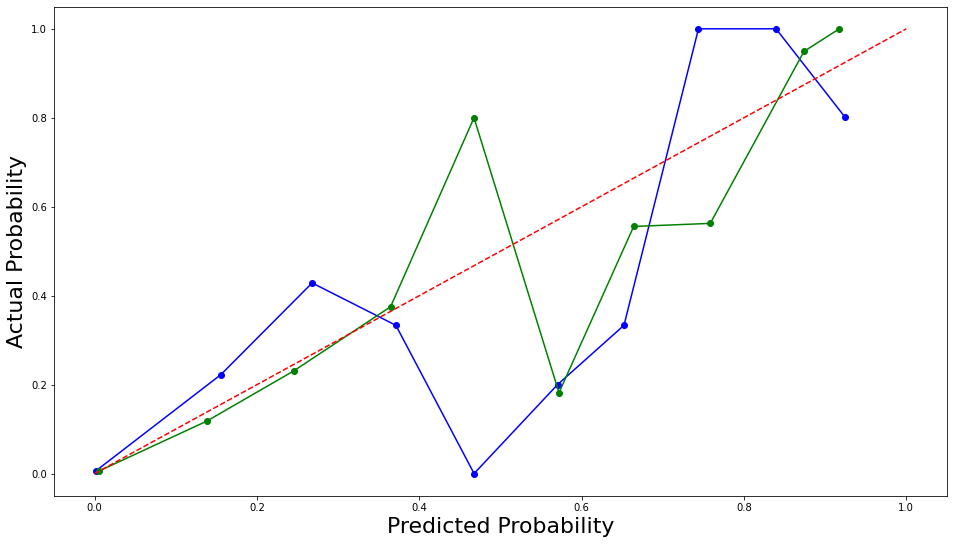

In [68]:
# Plot model calibration curve

prob_true, prob_pred = calibration_curve(y_test, clf_nn.predict_proba(X_test_tfidf)[:,1], n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, calibrated_clf.predict_proba(X_test_tfidf)[:,1], n_bins=10)

plt.figure(figsize=(16,9))
_ = plt.plot(prob_pred, prob_true, 'bo-')
_ = plt.plot(prob_pred_cal, prob_true_cal, 'go-')
_ = plt.plot([0,1], [0,1], 'r--')
plt.xlabel("Predicted Probability", fontsize=22)
plt.ylabel("Actual Probability", fontsize=22)

# Prediction Uncertainty

## Logistic Regression

In [26]:
# use bootstrapping to estimate confidence intervals for predictions

from sklearn.ensemble import BaggingClassifier

clf_bootstrap = BaggingClassifier(base_estimator=LogisticRegression(),
                       n_estimators=5, random_state=0).fit(X_train_tfidf, y_train)

# Accessing each base_estimator (already fitted)
preds = []
for m in clf_bootstrap.estimators_:
    preds.append(m.predict_proba(X_test_tfidf)[:,1])
    preds.append(m.predict_proba(X_test_tfidf)[:,1])
    
pred_stds = np.vstack(preds).std(axis=0)
pred_mean = np.vstack(preds).mean(axis=0)

# Get predictions and view performance
y_pred = clf_bootstrap.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2634
           1       0.88      0.69      0.77       131

    accuracy                           0.98      2765
   macro avg       0.93      0.84      0.88      2765
weighted avg       0.98      0.98      0.98      2765



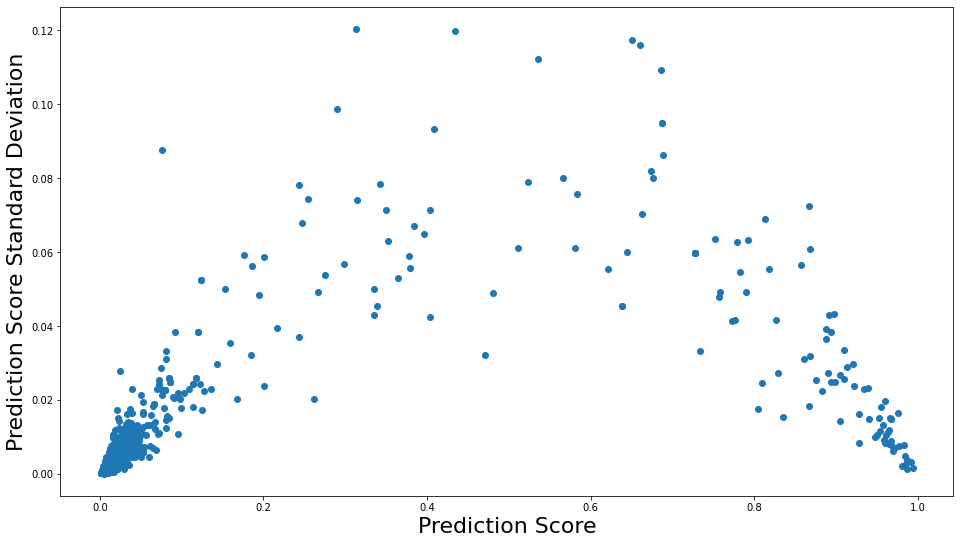

In [27]:
plt.figure(figsize=(16,9))
_ = plt.scatter(pred_mean, pred_stds)
_ = plt.xlabel("Prediction Score", fontsize=22)
_ = plt.ylabel("Prediction Score Standard Deviation", fontsize=22)

## Simple Neural Network

In [70]:
# use bootstrapping to estimate confidence intervals for predictions

from sklearn.ensemble import BaggingClassifier

clf_nn = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(128,128,2),
                       batch_size=64, max_iter=30, learning_rate_init=0.01)
clf_bootstrap = BaggingClassifier(base_estimator=clf_nn,
                       n_estimators=5).fit(X_train_tfidf, y_train)

# Accessing each base_estimator (already fitted)
preds = []
for m in clf_bootstrap.estimators_:
    preds.append(m.predict_proba(X_test_tfidf)[:,1])
    
pred_stds = np.vstack(preds).std(axis=0)
pred_mean = np.vstack(preds).mean(axis=0)

# Get predictions and view performance
y_pred = clf_bootstrap.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

/Users/dscripka/anaconda3/envs/ignite@v1.3.0/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/dscripka/anaconda3/envs/ignite@v1.3.0/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2634
           1       0.89      0.75      0.81       131

    accuracy                           0.98      2765
   macro avg       0.94      0.87      0.90      2765
weighted avg       0.98      0.98      0.98      2765



/Users/dscripka/anaconda3/envs/ignite@v1.3.0/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


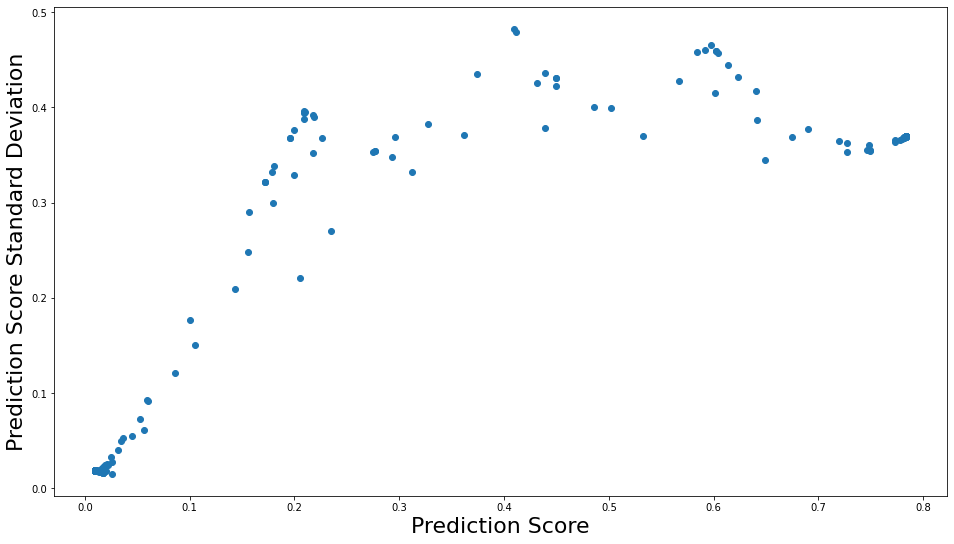

In [71]:
plt.figure(figsize=(16,9))
_ = plt.scatter(pred_mean, pred_stds)
_ = plt.xlabel("Prediction Score", fontsize=22)
_ = plt.ylabel("Prediction Score Standard Deviation", fontsize=22)

# Data Sampling and Evaluation

In [31]:
# Get texts for governing law and all other fields

excluded = ["__elem__token", "__elem__sentence", "__elem__entity"]

gov_law_text = [LumeText(lm).get_text_from_element(el) for lm in lumes for el in lm.elements if el.element_type == '__elem__Governing Law']
other_text = [LumeText(lm).get_text_from_element(el) for lm in lumes for el in lm.elements if el.element_type != '__elem__Governing Law' and el.element_type not in excluded]


all_text = gov_law_text + other_text
labels = [1]*len(gov_law_text) + [0]*len(other_text)

# View some example texts

gov_law_text[0:2]

['By this Agreement the Participants enter into a general Joint Venture (the "Joint Venture") in accordance with the laws of The State of Florida.',
 'This Agreement shall be governed by, construed, and enforced in accordance with the laws of the State of Texas, without regard to choice of  law principles that would require the application of the laws of any other jurisdiction.']

100%|██████████| 19/19 [00:13<00:00,  1.43it/s]


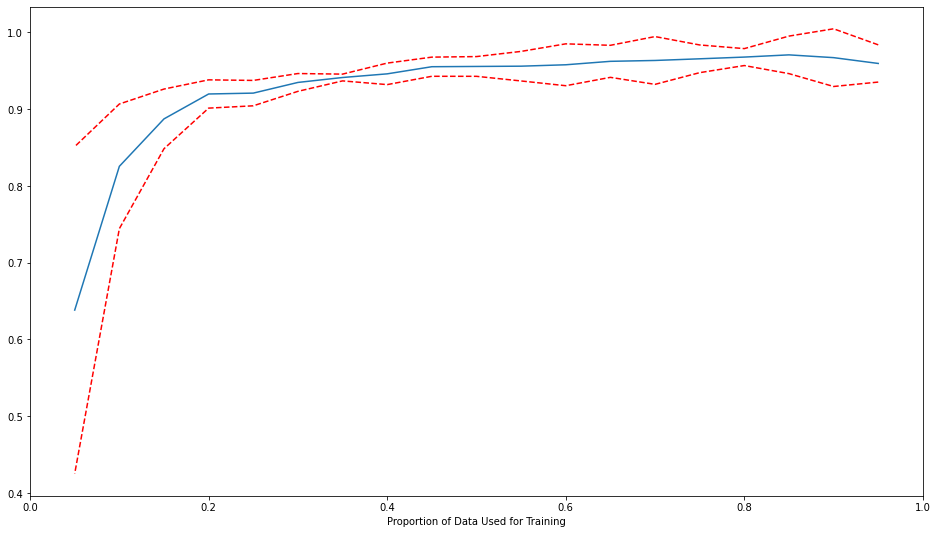

In [33]:
# Make LR classifier with TF-IDF features, plot learning curve

f1 = []
f1_std = []
prop = np.arange(1,20)/20.0
for i in tqdm(prop):
    # Preprocessing for TF-IDF
    feats = TfidfVectorizer(stop_words='english', ngram_range=(1,1), lowercase=True, max_features=1000)
    feats.fit(X_train)
    
    cv = ShuffleSplit(n_splits=5, test_size=i, random_state=1)
    clf = LogisticRegression()
    f1s = cross_val_score(clf, feats.transform(all_text), labels, cv=cv, scoring='f1')

    f1.append(np.mean(f1s))
    f1_std.append(np.std(f1s))

plt.figure(figsize=(16,9))
plt.xlim(0,1)
plt.xlabel("Proportion of Data Used for Training")
_ = plt.plot(prop[::-1], f1)
_ = plt.plot(prop[::-1], np.array(f1)-np.array(f1_std)*1.96, 'r--')
_ = plt.plot(prop[::-1], np.array(f1)+np.array(f1_std)*1.96, 'r--')

## Explore Distribution of Language

In [39]:
# Find Governing law texts with similar language (using regex)

# examples: "shall be governed by", "...laws of the state"

sim_language = [i for i in gov_law_text if \
                re.search("(shall|will)\s+be\s+governed\s+by", i, flags=re.IGNORECASE) or \
                re.search("laws\s+of\s+the\s+state\s+", i, flags=re.IGNORECASE)
               ]
#fp = [i for i in other_text if re.search("(shall|will)\s+be\s+governed\s+by", i, flags=re.IGNORECASE)]
len(sim_language), len(gov_law_text)

(405, 464)

In [40]:
# Make new evaluation split based on regex searches

X_train2 = [i for ndx, i in enumerate(gov_law_text) if i in sim_language]
X_test2 = [i for ndx, i in enumerate(gov_law_text) if i not in sim_language]

X_train_, X_test_ = train_test_split(other_text, test_size=0.20, random_state=1)

y_train2 = [1]*len(X_train2) + [0]*len(X_train_)
X_train2 = X_train2 + X_train_
y_test2 = [1]*len(X_test2) + [0]*len(X_test_)
X_test2 = X_test2 + X_test_


# Get features and train model
feats = TfidfVectorizer(stop_words='english', ngram_range=(1,1), lowercase=True, max_features=1000)
feats.fit(X_train2)
X_train_tfidf2 = feats.transform(X_train2)
X_test_tfidf2 = feats.transform(X_test2)

clf = LogisticRegression()
clf.fit(X_train_tfidf2, y_train2)

# View performance
y_pred = clf.predict(X_test_tfidf2)
print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2672
           1       1.00      0.58      0.73        59

    accuracy                           0.99      2731
   macro avg       1.00      0.79      0.86      2731
weighted avg       0.99      0.99      0.99      2731



## Simulate OOD (out-of-domain) test data

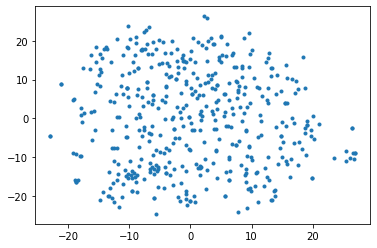

In [42]:
# Fit T-SNE
gov_law_feats = feats.transform(gov_law_text)
X_embedded = TSNE(n_components=2).fit_transform(gov_law_feats)

# Plot
_ = plt.scatter(X_embedded[:,0], X_embedded[:,1], marker='.')

In [43]:
# Find Governing law texts with similar language (using cosine similarity)

ref = gov_law_feats[348] # 'This Agreement shall be governed by the laws of the State of Iowa.'

ood = []
for ndx, val in enumerate(gov_law_feats):
    if cosine_similarity(val, ref) < 0.4:
        ood.append(ndx)
        
len(ood)

137

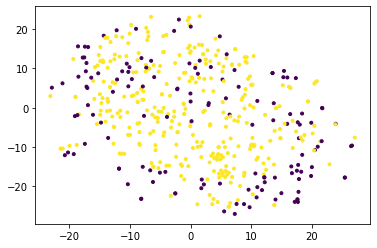

In [44]:
# Fit T-SNE
gov_law_feats = feats.transform(gov_law_text)
X_embedded = TSNE(n_components=2).fit_transform(gov_law_feats)

# Plot
_ = plt.scatter(X_embedded[:,0], X_embedded[:,1], marker='.', c=[1 if ndx not in ood else 0 for ndx, i in enumerate(gov_law_text)])

In [45]:
# Make new split based on cosine similarity

X_train2 = [i for ndx, i in enumerate(gov_law_text) if ndx not in ood]
X_test2 = [i for ndx, i in enumerate(gov_law_text) if ndx in ood]

X_train_, X_test_ = train_test_split(other_text, test_size=0.20, random_state=1)

y_train2 = [1]*len(X_train2) + [0]*len(X_train_)
X_train2 = X_train2 + X_train_
y_test2 = [1]*len(X_test2) + [0]*len(X_test_)
X_test2 = X_test2 + X_test_


feats = TfidfVectorizer(stop_words='english', ngram_range=(1,3), lowercase=True, max_features=1000)
feats.fit(X_train2)
X_train_tfidf2 = feats.transform(X_train2)
X_test_tfidf2 = feats.transform(X_test2)

clf = LogisticRegression()
clf.fit(X_train_tfidf2, y_train2)

y_pred = clf.predict(X_test_tfidf2)

print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2672
           1       1.00      0.61      0.75       137

    accuracy                           0.98      2809
   macro avg       0.99      0.80      0.87      2809
weighted avg       0.98      0.98      0.98      2809

